# **Tanzanian Water Wells Prediction**

---


### **Authors:** [Abduba Galgalo](https://github.com/Abduba011), [Faith Makokha](https://github.com/faithmaks), [Femi Kamau](https://github.com/ctrl-Karugu), [John Mungai](https://github.com/Johnspes), [Susan Mungai](https://github.com/SueMungai), and [Willy Angole](https://github.com/Willy-Angole)

## 1. Business Understanding

### Problem Statement
Tanzania is currently failing to meet the potable water requirements for its population.  Despite already building water wells to offset this problem, many are unfortunately non-functional and others are in need of repair. 
As a result,  our stakeholder, WHO, has narrowed down their interest to drilling more water wells and maintaining/ revamping  existing ones within the country, in an effort to ensure availability of quality and quantity drinking water countrywide . 

Our role as the data scientist in this project will be to identify patterns in non-functional wells, with the aim of influencing how new ones are built. Furthermore, using these patterns, we will enable our stakeholder to accurately predict existing water points in need of intervention ensuring the people of Tanzania have access to clean potable water. 

### Specific Objectives
* To identify the trends/patterns between both non-functional and functional wells 
* To identify non-functioning wells using a simple analysis, and predict the functionality of a well based on available variables
### Research Questions
* How can we apply  Machine Learning and necessary classification methods to predict  functionality  of  wells in Tanzania?
* Are there any common features that are consistent with  functional and non-functional wells?
* Can we identify ways to help build better wells?

### Success Metrics 
* To ensure that newly constructed wells are of good quality water for the communities.
* To  correctly identify functionality of a well and determine its viability.
* Generating a model that will be able to correctly predict the quality status of the wells in Tanzania with an accuracy of 80%.


## 2. Data Understanding

> This phase is broken down into four tasks together with its projected outcome or output in detail:
> - Collect Initial Data
> - Describe Data
> - Explore Data
> - Verify Data Quality

The data for this project was provided by our stakeholder, the World Health Organization. This data consists of information from various wells in Tanzania.

##### Load Libraries

In [1]:
!pip install missingno

In [2]:
# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# modeling


# styling
import warnings
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 40)
warnings.filterwarnings('ignore')

##### Load Data

In [3]:
# Load the well values data into pandas DataFrame
df_values = pd.read_csv("./data/well_data_values.csv", index_col=0)

# Load the well labels data into pandas DataFrame
df_labels = pd.read_csv("./data/well_data_labels.csv", index_col=0)

# Print the shape of the two DataFrames to check if they are good to join/merge
print(df_values.shape)
print(df_labels.shape)

# Create a combined DataFrame with both the value and label data joined on the 'id' column
data = df_values.join(df_labels, on='id')

# Preview the DataFrame
data.head(5)

(59400, 39)
(59400, 1)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [4]:
# Describe the the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [5]:
# Numerical Columns
print(f"Numerical Columns: {data.select_dtypes(include='number').columns}\n")

# Categorical Columns
print(f"Categorical Columns: {data.select_dtypes(include='object').columns}")

Numerical Columns: Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

Categorical Columns: Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


The dataset consists of 40 columns and 59400 records. These are:
- **Numerical Columns (9)**

    `amount_tsh` - Total static head (amount water available to waterpoint)

    `gps_height` - Altitude of the well

    `longitude` - GPS coordinate

    `latitude` - GPS coordinate

    `num_private` - 

    `region_code` - Geographic location (coded)

    `district_code` - Geographic location (coded)

    `population` - Population around the well

    `construction_year` : Year the waterpoint was constructed

- **Categorical Columns (31)**

    `date_recorded` - The date the row was entered

    `installer` - Organization that installed the well
  
    `funder` - Who funded the well

    `wpt_name` - Name of the waterpoint if there is one

    `basin` - Geographic water basin

    `subvillage` - Geographic location

    `region` - Geographic location

    `lga` - Geographic location

    `ward` - Geographic location

    `public_meeting` - True/False

    `recorded_by` - Group entering this row of data

    `scheme_management` - Who operates the waterpoint

    `scheme_name` - Who operates the waterpoint

    `permit` - If the waterpoint is permitted

    `extraction_type` - The kind of extraction the waterpoint uses

    `extraction_type_group` - The kind of extraction the waterpoint uses

    `extraction_type_class` - The kind of extraction the waterpoint uses

    `management` - How the waterpoint is managed

    `management_group` - How the waterpoint is managed

    `payment` - What the water costs

    `payment_type` - What the water costs

    `water_quality` - The quality of the water

    `quality_group` - The quality of the water

    `quantity` - The quantity of water

    `quantity_group` - The quantity of water

    `source` - The source of the water

    `source_type` - The source of the water

    `source_class` - The source of the water

    `waterpoint_type` - The kind of waterpoint

    `waterpoint_type_group` - The kind of waterpoint

    `status_group`- The condition of the wells (target variable)

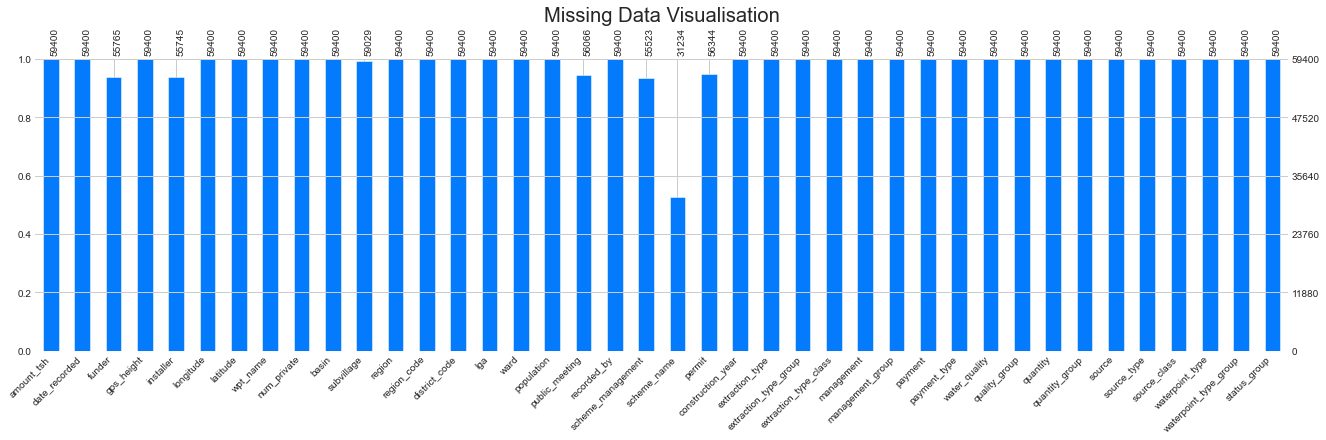

In [6]:
# Visualise the missing data in the DataFrame
msno.bar(data, figsize=(20, 5), fontsize=(10), color='#037bfc')
plt.title("Missing Data Visualisation")
plt.xticks(rotation = 90, fontsize=10);

The overall dataset does not contain much missing data. However, the `scheme_name` column is missing approximately half its data.

In [7]:
# Describe the numerical data
data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


From the numerical column description, we can see that the data is 

## 3. Data Preparation
> This phase, which is often referred to as “data munging”, prepares the final data set(s) for modeling. It has the following tasks:
> - Select Data
> - Clean Data
> - EDA

### 3.1 Select Data
> In this section, we determine which columns we intend to use.

We observed that out of the 40 columns that we have in our dataset, most seem to be related to each other. Therefore, we are going to compare the related columns in order to evaluate the truth of the previous statement, and if so, also select the most appropriate columns.

The metrics that we shall employ to evaluate the related columns are:
- Value Counts

We shall also be selecting columns based on their ability to answer our business and research questions.

#### 3.1.1 `scheme_management` | `management` | `management_group`

The `scheme_management`, `management`, and `management_group`columns are all 'management of the well' related columns. We shall begin by evaluating their value counts in order to check the similarity of data

In [8]:
# Find the value counts of the scheme_management column
data['scheme_management'].value_counts(dropna=False)

VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [9]:
# Find the value counts of the management column
data['management'].value_counts(dropna=False)

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [10]:
# Find the value counts of the management_group column
data['management_group'].value_counts(dropna=False)

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

Looking at the management colmns, we can see `scheme_management` and `management` are related. However, `management_group` is not related to the other two columns, and it contains fewer unique values than the others. Between `scheme_management` and `management`, we see that `scheme_management` contains more missing values. Therefore, it would be better to work with `management` instead of `scheme_management`.

As for the `management_group` column, we will perform a groupby operation on the pandas dataframe to evaluate the relationship between the `management_group` and the `management` columns.

In [11]:
# Create a copy of the DataFrame and drop the scheme_management column from it
new_data = data.copy().drop(['scheme_management'], axis=1)

# Group the data by the management_group column and the management column
pd.DataFrame(new_data.groupby(['management_group', 'management']).size())

0
management_group management             
commercial       company             685
                 private operator   1971
                 trust                78
                 water authority     904
other            other               844
                 other - school       99
parastatal       parastatal         1768
unknown          unknown             561
user-group       vwc               40507
                 water board        2933
                 wua                2535
                 wug                6515

We can see that there is a relationship between the `management_group` and the `management` columns. However, the `management_group` column contains fewer unique values than the `management` column. In order to avoid the curse of dimensionality, we will drop the `management_group` column.

#### 3.1.2 `extraction_type` | `extraction_type_group` | `extraction_type_class`

The `extraction_type`, `extraction_type_group`, and `extraction_type_class` are all 'extraction type' related columns. We shall begin by evaluating their value counts in order to check the similarity of data

In [12]:
# Find the value counts of the 'extraction_type' column
data['extraction_type'].value_counts(dropna=False)

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [13]:
# Find the value counts of the 'extraction_type_group' column
data['extraction_type_group'].value_counts(dropna=False)

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [14]:
# Find the value counts of the 'extraction_type_class' column
data['extraction_type_class'].value_counts(dropna=False) 

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

Once again, we can see that the `extraction_type` and `extraction_type_group` columns are related. However, `extraction_type_class` is not related to the other two columns, and it contains fewer unique values than the others. All in all, we can see that these three columns contain the same information. Therefore, we shall evaluate the groupby operation on all three of them.

In [15]:
# Group the data by the extraction_type, extraction_type_group, and extraction_type_class
pd.DataFrame(new_data.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type']).size())

0
extraction_type_class extraction_type_group extraction_type                 
gravity               gravity               gravity                    26780
handpump              afridev               afridev                     1770
                      india mark ii         india mark ii               2400
                      india mark iii        india mark iii                98
                      nira/tanira           nira/tanira                 8154
                      other handpump        other - mkulima/shinyanga      2
                                            other - play pump             85
                                            other - swn 81               229
                                            walimi                        48
                      swn 80                swn 80                      3670
motorpump             mono                  mono                        2865
                      other motorpump       cemo                          90
                                            climax                        32
other                 other                 other                       6430
rope pump             rope pump             other - rope pump            451
submersible           submersible           ksb                         1415
                                            submersible                 4764
wind-powered          wind-powered          windmill                     117

In this case, we shall use the `extraction_type_group`, this is because it is more detailed than the `extraction_type_class` column, and it contains fewer unique values than the `extraction_type` column. Therefore, we are able to balance the curse of dimensionality and the information contained in the column.

In [16]:
# Drop the extraction_type_class and extraction_type columns
new_data = new_data.drop(['extraction_type_class', 'extraction_type'], axis=1)

#### 3.1.3 `payment` | `payment_type`

The `payment` and `payment_type` columns are both monetary related columns. We shall begin by evaluating their value counts in order to check the similarity of data

In [17]:
# Find the value counts of the 'payment' column
data['payment'].value_counts(dropna=False)

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [18]:
# Find the value counts of the 'payment_type' column
data['payment_type'].value_counts(dropna=False)

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

The `payment` and `payment_type` columns are perfectly related. Therefore, we shall drop the `payment` as it is a little bit too wordy compared to the `payment_type` column.

In [19]:
# Drop the payment column
new_data = new_data.drop(['payment'], axis=1)

#### 3.1.4 `water_quality` | `quality_group`
The `water_quality` and `quality_group` are both related columns that talk about the quality of the water from the well. We shall begin by evaluating their value counts in order to check the similarity of data.

In [20]:
# Find the value counts of the 'water_quality' column
data['water_quality'].value_counts(dropna=False)

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [21]:
# Find the value counts of the 'quality_group' column
data['quality_group'].value_counts(dropna=False)

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

The `water_quality` column contains more unique values than the `quality_group` column. However, the difference is not that big. Therefore, we shall drop the `quality_group` column as it contains less information.

In [22]:
# Drop the quality_group column
new_data = new_data.drop(['quality_group'], axis=1)

#### 3.1.5 `quantity` | `quantity_group`
The `quantity` and `quantity_group` are both related columns that talk about the quantity of the water from the well. We shall begin by evaluating their value counts in order to check the similarity of data.

In [23]:
# Find the value counts of the 'quantity' column
data['quantity'].value_counts(dropna=False)

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [24]:
# Find the value counts of the 'quantity_group' column
data['quantity_group'].value_counts(dropna=False)

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

The `quantity` and `quantity_group` columns are perfectly related. Therefore, we can drop either. We shall drop the `quantity_group` column.

In [25]:
# Drop the quantity_group column
new_data = new_data.drop(['quantity_group'], axis=1)

#### 3.1.6 `source` | `source_type` | `source_class`
The `source`, `source_type`, and `source_class` are all related columns that talk about the source of the water from the well. We shall begin by evaluating their value counts in order to check the similarity of data.

In [26]:
# Find the value counts of the 'source' column
data['source'].value_counts(dropna=False)

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [27]:
# Find the value counts of the 'source_type' column
data['source_type'].value_counts(dropna=False)

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [28]:
# Find the value counts of the 'source_class' column
data['source_class'].value_counts(dropna=False)

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

From the value counts, we can see that the `source` column contains more unique values than the `source_type` column, and the `source_type` column contains more unique values than the `source_class` column. We will once again be settling for the `source_type` column as it contains more information than the `source_class` column, and it contains fewer unique values than the `source` column. It allows us to balance the curse of dimensionality and the information contained in the column.

In [29]:
# Drop the 'source' and 'source_class' columns
new_data = new_data.drop(['source', 'source_class'], axis=1)

#### 3.1.7 `waterpoint_type` | `waterpoint_type_group`
The `waterpoint_type` and `waterpoint_type_group` are both related columns that talk about the type of the waterpoint. We shall begin by evaluating their value counts in order to check the similarity of data.

In [30]:
# Find the value counts of the 'waterpoint_type' column
data['waterpoint_type'].value_counts(dropna=False)

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [31]:
# Find the value counts of the 'waterpoint_type_group' column
data['waterpoint_type_group'].value_counts(dropna=False)

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

From the value counts, we can see that the `waterpoint_type` column contains more unique values than the `waterpoint_type_group`. Therefore, we keep the `waterpoint_type` column as it contains more detail than the `waterpoint_type_group` column.

In [32]:
# Drop the waterpoint_type_group column
new_data = new_data.drop(['waterpoint_type_group'], axis=1)

#### 3.1.8 `longitude` | `latitude` 

In [33]:
# Drop the longitude and latitude columns
new_data = new_data.drop(['longitude', 'latitude'],axis = 1)


We have dropped the longitude and latitude columns as it will not prove useful in our analysis and classification. We will use the columns that contain geographical locations instead.

#### 3.1.9 `wpt_name` 

In [34]:
# Drop the waterpoint name column
new_data = new_data.drop(['wpt_name'], axis=1)

The name of the waterpoint will not prove of any help to predicting the functionality of the water wells 

#### 3.1.10 `num_private`

In [35]:
# Drop the num_private column 
new_data = new_data.drop(['num_private'], axis=1)

The column was useless as the values were filled with zeros. 

#### 3.1.11 `region_code` 

In [36]:
#Drop the region_code column 
new_data = new_data.drop(['region_code'], axis=1)

We already have the region column which will prove of more benefit than their codes.

#### 3.1.12 `district_code`

In [37]:
# Drop the district_code column
new_data = new_data.drop(['district_code'], axis=1)

We already have the district column which will prove of more benefit than their codes.

#### 3.1.13 `public_meeting`

In [38]:
# Drop the public_meeting column
new_data = new_data.drop(['public_meeting'], axis=1)

It does not have any useful data to help with our predictive modeling

#### 3.1.14 `recorded_by` 

In [39]:
# Drop the recorded_by column
new_data = new_data.drop(['recorded_by'], axis=1)

The data stipulated within the column does not add any value to our analysis, as it is only one value for the records.

#### 3.1.15 `scheme_name`


In [40]:
# Drop the scheme_name column
new_data = new_data.drop(['scheme_name'], axis=1)

The column is missing almost half of it's data, which will prove as useless

In [41]:
new_data.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'basin', 'subvillage', 'region', 'lga', 'ward', 'population', 'permit',
       'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source_type', 'waterpoint_type', 'status_group'],
      dtype='object')

The data selection will be influenced by the objectives and research questions stipulated in the business understanding phase

**Numerical Columns**

- `gps_height`
- `population`
- `amount_tsh`
- `date_recorded`
- `construction_year`

**Categorical Columns**

- `funder`
- `installer`
- `basin`
- `subvillage`
- `region`
- `lga`
- `ward`
- `scheme_manag`
- `permit`
- `extraction_type_group`
- `payment_type`
- `management_group`
- `water_quality`
- `quantity`
- `source_type`
- `waterpoint_type`
- `status_group`

### 3.2 Clean Data
> In this section, we will be looking at the missing values in the dataset as well as the duplicate records in the dataset.

#### 3.2.1 Completeness
> We will be considering the completeness of the dataset in this section. In this section, we will be looking at the missing values in the dataset.

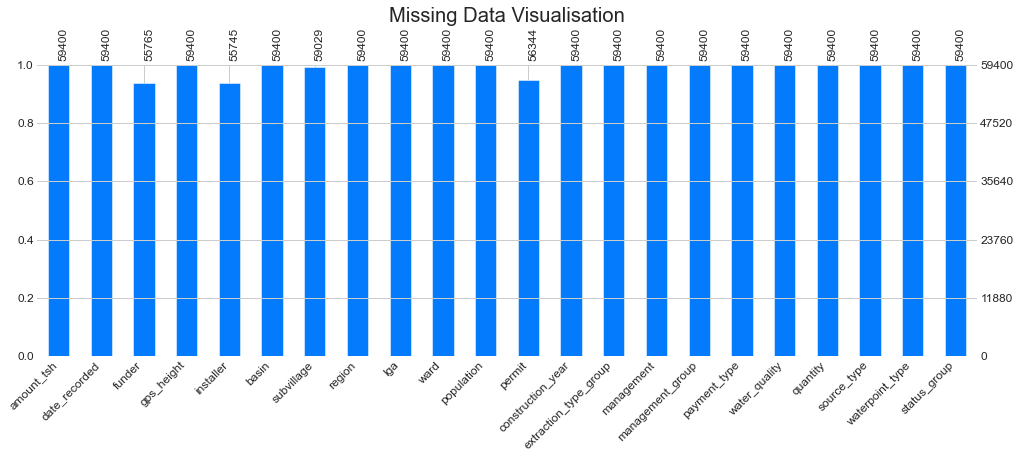

In [42]:
# We shall visualise the missing values in the new dataset
msno.bar(new_data, figsize=(15, 5), color='#037bfc', fontsize=12)
plt.title("Missing Data Visualisation")
plt.xticks(rotation = 90);

From the visualisation above, we have identified the following columns to contain missing data:
- `funder`
- `installer`
- `subvillage`
- `scheme_management`
- `permit`

>[ ] Are the missing values random? Missing value research is needed

We will be writing a function that calculates the missing values within the dataset. The function will output the total number of missing values, as well as the percentage that the missing values account for.

In [43]:
def missing_values(df, col):
    """
    This function evaluates the total number of missing values in a column and
    the respective percentages
    """
    print(f"Missing Values: {df[col].isna().sum()}")
    print(f"Percentage: {round((df[col].isna().sum() / len(df)) * 100, 2)}%")

##### 3.2.1.1 `funder`

In [44]:
# Evaluate the missing values in the funder column
missing_values(new_data, 'funder')

Missing Values: 3635
Percentage: 6.12%


The missing values in the `funder` column account for 6.12% of the values in the dataset. Furthermore, this is information that cannot be accessed online. Therefore, we will be dropping the missing values in this column.

In [45]:
# Drop the missing values
new_data.dropna(axis=0, subset=['funder'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['funder'].value_counts(dropna=False)

(55765, 22)


Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Balyehe                      1
Member O                     1
Sido                         1
Ldcdd                        1
Kanis                        1
Name: funder, Length: 1897, dtype: int64

##### 3.2.1.2 `installer`

In [46]:
# Evaluate the missing values in the installer column
missing_values(new_data, 'installer')

Missing Values: 73
Percentage: 0.13%


The `installer` column only contains 73 missing values, this accounts for 0.13% of the total data. This is a very small percentage of the total data. Therefore, we can drop the records containing missing `installer` values.

In [47]:
# Drop the missing values
new_data.dropna(axis=0, subset=['installer'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['installer'].value_counts(dropna=False)

(55692, 22)


DWE                             17390
Government                       1825
RWE                              1206
Commu                            1060
DANIDA                           1050
                                ...  
RC MISSION                          1
LOLMOLOKI                           1
KAEM                                1
JAPAN                               1
Kitiangare village community        1
Name: installer, Length: 2139, dtype: int64

##### 3.2.1.3 `subvillage`

In [48]:
# Evaluate the missing values in the subvillage column
missing_values(new_data, 'subvillage')

Missing Values: 371
Percentage: 0.67%


The subvillage column has 371 missing values. This accounts for 0.67% of the total data. Therefore, we can drop the missing values

In [49]:
# Drop the missing values
new_data.dropna(axis=0, subset=['subvillage'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['subvillage'].value_counts(dropna=False)

(55321, 22)


Shuleni      485
Madukani     484
Majengo      478
Kati         366
Mtakuja      252
            ... 
Mero Kati      1
Bwila Juu      1
Masengwa       1
Mwamkulu       1
Mwakijiko      1
Name: subvillage, Length: 18285, dtype: int64

##### 3.2.1.5 `permit`

In [50]:
# Evaluate the missing values in the permit column
missing_values(new_data, 'permit')

Missing Values: 632
Percentage: 1.14%


There are 632 missing values in the `permit` column. We will be dropping the missing values as they only account for 1.14% of all the data in the column.

In [51]:
# Drop the missing values
new_data.dropna(axis=0, subset=['permit'], inplace=True)

# New shape of the dataframe
print(new_data.shape)

# Check the value counts
new_data['permit'].value_counts(dropna=False)

(54689, 22)


True     38104
False    16585
Name: permit, dtype: int64

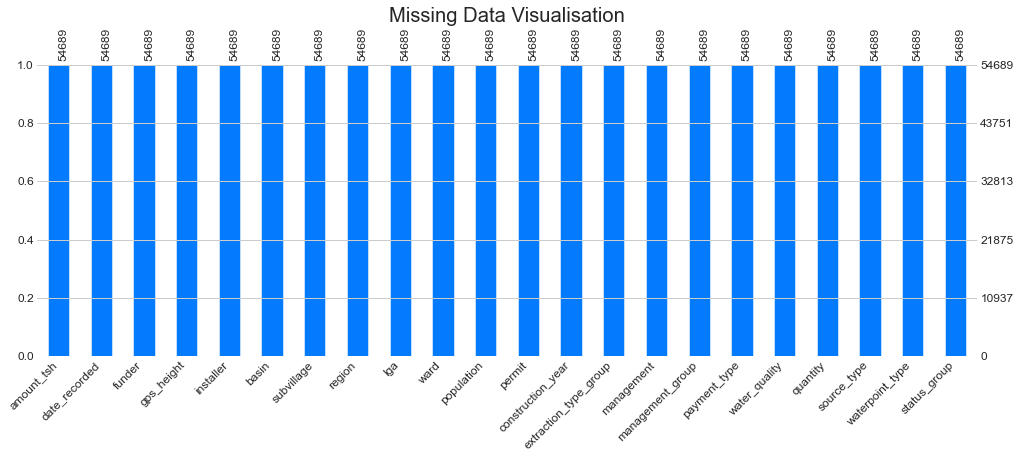

In [52]:
# We shall visualise the missing values in the new dataset
msno.bar(new_data, figsize=(15, 5), color='#037bfc', fontsize=12)
plt.title("Missing Data Visualisation")
plt.xticks(rotation = 90);

We can confirm that our data does not contain more missing values and we can move on to observing the duplicated data.

#### 3.2.2 Validity
> In this section, we will be looking at the validity of the data. We will be looking at the following:
>  - Duplicated Data
>  - Outliers

##### 3.2.2.1 Duplicated Data
> Duplicated data refers to data that has been imputted more than once. Duplicated data does not always mean that the data is invalid. However, it is important to note that duplicated data can lead to overfitting of the model.

In [53]:
# Find the duplicated records
new_data[new_data.duplicated()]

,amount_tsh,date_recorded,funder,gps_height,installer,basin,subvillage,region,lga,ward,population,permit,construction_year,extraction_type_group,management,management_group,payment_type,water_quality,quantity,source_type,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,,,
59310,0.0,2011-07-18,Government Of Tanzania,0,Government,Lake Victoria,Nyanza,Mwanza,Geita,Kalangalala,0,True,0,submersible,vwc,user-group,never pay,soft,insufficient,borehole,communal standpipe,functional
2296,0.0,2011-07-31,Kkkt_makwale,0,KKKT _ Konde and DWE,Lake Nyasa,Isimba,Mbeya,Kyela,Makwale,0,True,0,gravity,vwc,user-group,never pay,soft,enough,spring,communal standpipe,functional
53399,0.0,2011-07-23,Danida,0,Central government,Lake Nyasa,Malungo,Mbeya,Kyela,Mwaya,0,True,0,gravity,vwc,user-group,never pay,soft,dry,spring,communal standpipe,non functional
2859,0.0,2011-07-31,Kkkt_makwale,0,KKKT _ Konde and DWE,Lake Nyasa,Isimba,Mbeya,Kyela,Makwale,0,True,0,gravity,vwc,user-group,never pay,soft,enough,spring,communal standpipe,functional
70330,0.0,2011-04-12,Rc Church,0,RC Church,Lake Nyasa,Matwalani,Mbeya,Mbeya Rural,Ulenje,0,False,0,gravity,wug,user-group,on failure,soft,enough,river/lake,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16666,0.0,2011-07-26,Md,0,DW,Lake Victoria,Kishoju 1,Kagera,Muleba,Nshamba,0,True,0,submersible,vwc,user-group,never pay,soft,enough,spring,communal standpipe,non functional
5064,0.0,2011-07-12,Hesawa,0,HESAWA,Lake Victoria,Mishenye,Kagera,Bukoba Rural,Buterankuzi,0,True,0,gravity,vwc,user-group,monthly,soft,enough,river/lake,communal standpipe,functional
47527,0.0,2011-04-12,Rc Church,0,RC Church,Lake Nyasa,Mjimwema,Mbeya,Mbeya Rural,Ulenje,0,False,0,gravity,wug,user-group,on failure,soft,enough,river/lake,communal standpipe,functional


Our dataset contains duplicated records, however, a duplicated record does not necessarily mean that the data is incorrect. Instead, they mean that a multiple wells were built under the same project, therefore, all the features will be similar.

##### 3.2.2.2 Outliers

> Outliers are data points that are significantly different from the rest of the data. Outliers can be caused by human error, or they can be a result of the data collection process. Outliers can be caused by a number of factors, including:
> - Measurement error (Instrument error)
> - Data entry error (Human error)
> - Changes in system behaviour
> - Fraudulent Behaviour
> - Natural deviations in populations


We will be performing outlier treatment on the numerical columns in out dataset. These are:
- `amount_tsh`
- `gps_height`
- `population`
- `construction_year`

The reason as to why we do outlier treatment is because:
- It increases the error variance and reduces the power of statistical tests
- If the outliers are non-randomly distributed, they can decrease normality

We shall create a function to evaluate the outliers in the numerical columns within our dataset by use of boxplots.

In [54]:
def outliers(df, col, title):
    """
    This function visualises the outliers and outputs boxplots
    """
    plt.figure(figsize=(10,2))
    sns.boxplot(x=col, data=df)
    plt.title(title, fontsize=15);

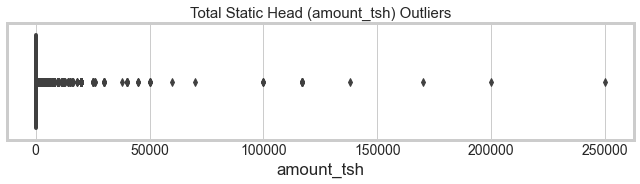

In [55]:
# Visualise the outliers in the amount_tsh column
outliers(new_data, 'amount_tsh', 'Total Static Head (amount_tsh) Outliers')

In the total static head boxplot, we can see that there are outliers in the data. However, the outliers do not represent erroneous data as it is possible to have a total static head of even 250,000. Therefore, we will not be removing the outliers. It is also worth noting that the majority of the data is clustered around 0. This will need to be further investigated in univariate analysis.

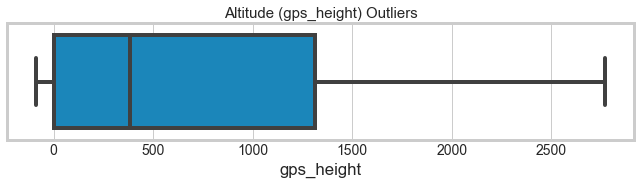

In [56]:
# Visualise the outliers in the amount_tsh column
outliers(new_data, 'gps_height', 'Altitude (gps_height) Outliers')

From the gps_height column, we can see that there are no outliers. This means that we do not need to treat this data for outliers.

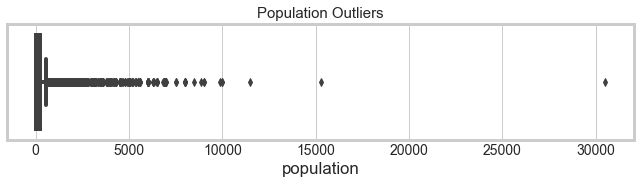

In [57]:
# Visualise the outliers in the population column
outliers(new_data, 'population', 'Population Outliers')

In the visualisation above, we see that there are outliers in the population column. However, the outliers do not represent erroneous data as it is possible to have a population of even 30,000. Therefore, we will not be removing the outliers. Population is a region dependent variable, therefore, it is possible to have a population of upto even 30,000 people living near a particular well.

In order to confirm this, we will identify records that contain significant outliers in the population column, and confirm their validity through online research.

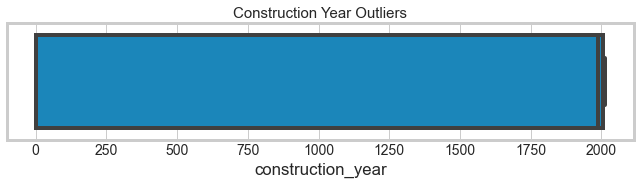

In [58]:
# Visualise the outliers in the construction_year column
outliers(new_data, 'construction_year', 'Construction Year Outliers')

From the boxplot above, we can see that the construction year column has no outliers in the column. However, we have noticed that there are some years that do not make sense. This means that the data is most probably affected by errors. We will be investigating this further in the univariate analysis. All in all, there are no outliers to treat in the construction year column.

#### 3.2.3 Uniformity
> In this section, we will be looking at the uniformity of the data. Uniformity refers to the consistency of the data with respect to the formatting, labelling. We will be looking at the following:
> - Labelling
> - Formatting

##### 3.2.3.1 Labelling
> Labelling refers to the consistency of the data with respect to the labelling of the data. We will be looking at the following:
> - Are the columns small case?
> - Are there any spaces?
> - Are they interpretable?

We will be writing a function that will check the labelling of the columns in the dataset. The function will output the columns that are not small case, as well as the columns that contain spaces.

In [59]:
# Write function to rename columns
def rename_columns(df, col):
    """ 
    This function re-formats the column names to ensure that they are all in lower case and contain no spaces
    """
    new_col = col.strip().replace(' ', '_').lower()
    
    df.rename(columns = {col: new_col}, inplace = True)

In [60]:
# Loop through all the column names and reformat them
for col in new_data.columns:
    rename_columns(new_data, col)

We will also be looking at the column names to ensure that they are interpretable

In [61]:
new_data.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'basin', 'subvillage', 'region', 'lga', 'ward', 'population', 'permit',
       'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source_type', 'waterpoint_type', 'status_group'],
      dtype='object')

Looking at the column names above, we can firstly confirm that the column names are small case. Furthermore, with the uniformity of the spaces, we can confirm that the column names are interpretable. As for the names of the columns, other than `lga`, the rest of the column names are interpretable.

In [62]:
# Rename the 'lga' column to 'local_government_area'
new_data.rename(columns = {'lga': 'local_government_area'}, inplace = True)

new_data.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'basin', 'subvillage', 'region', 'local_government_area', 'ward',
       'population', 'permit', 'construction_year', 'extraction_type_group',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source_type', 'waterpoint_type', 'status_group'],
      dtype='object')

##### 3.2.3.2 Formatting
> The formatting of the data refers to the consistency of the data with respect to the datatypes of the columns. We will be looking at the following:

In [63]:
# Write a function to to convert the columns to the appropriate data types
def convert_to_category(df, col):
    """
    This function converts the object categories to category data type
    """
    df[col] = df[col].astype('category')

In [64]:
# Write for loop to convert the object categoris to a category datatype
for col in new_data.select_dtypes(include='object').columns:
    convert_to_category(new_data, col)

In [65]:
# Convert the date_recorded to datetime format
new_data['date_recorded'] = pd.to_datetime(new_data['date_recorded'], infer_datetime_format=True)

# # Convert the construction_year to datetime format
# new_data['construction_year'] = pd.to_datetime(new_data['construction_year'], format='%Y')

#### 3.2.4 Consistency.

We shall be checking the `installer` and   `funder` columns and ensuring the spellings for certain values just to ensure there is no repetition/ ensure consistency of values.

In [66]:
new_data['installer'].value_counts()

DWE                  17312
Government            1788
RWE                   1202
DANIDA                1049
KKKT                   895
                     ...  
Mu                       1
Muhindi                  1
Mungaya                  1
Municipal Council        1
Madra                    1
Name: installer, Length: 2040, dtype: int64

In [67]:
# From the most common 100 value counts we realized some spelling mistakes or different syntax between same categories

# Replacing the spelling mistakes and collect same categories in same name

new_data['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)

new_data['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
new_data['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

new_data['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                  'District Council','Council','Counc','District  Council','Distri'),
                                 value ='District council' , inplace=True)
new_data
new_data['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                   'RC CATHORIC',) , value ='RC Church' , inplace=True)

new_data['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                    'central government','Cental Government', 'Cebtral Government', 
                                  'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                    'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                    'Centra govt') , value ='Central government' , inplace=True)

new_data['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                      value ='world vision' , inplace=True)

new_data['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
new_data['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

new_data['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                    'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                    'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                    'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                    'Village Office','Village community members'),
                                     value ='villagers' , inplace=True)

new_data['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                      value ='Community' , inplace=True)
new_data['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                      'Governme','Governmen' ) ,value ='Government' , inplace=True)

new_data['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)

In [68]:
# continue to replacing spellin mistakes and getting together values
new_data['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
new_data['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
new_data['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
new_data['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
new_data['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
new_data['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
new_data['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
new_data['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
new_data['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
new_data['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)




since we had dropped rows with missing values, lets go ahead and improve a few things...
- [we got some assistance from these project](https://github.com/ezgigm/Project3_TanzanianWaterWell_Status_Prediction/blob/master/STEP1_Cleaning_and_Exploring_Data.ipynb)

In [69]:
new_data.to_csv('cleaned_data.csv', index=False)

### 3.3 Exploratory Data Analysis
> In this section, we shall be exploring the columns in the dataset. We shall be performing the following:
> - Univariate Analysis
> - Bivariate Analysis
> - Multi-variate Analysis

#### 3.4.1 Univariate Analysis
> In this section, we'll explore each column in the dataset to see the distributions of features and obtain some useful insights. The main two parts in this section are: 
>   - Categorical Columns
>   - Numerical Columns

In [70]:
print(f"Categorical Columns: {(new_data.select_dtypes(include='object').columns)}")

Categorical Columns: Index([], dtype='object')


In [71]:
print(f"Numerical Columns: {(new_data.select_dtypes(include='number').columns)}")

Numerical Columns: Index(['amount_tsh', 'gps_height', 'population', 'construction_year'], dtype='object')


#### 3.4.1.1 Categorical Columns

There are 18 categorical columns in the dataset. We will be performing univariate analysis on these columns.

In [72]:
# Fuction to get the value counts of the data in the columns
def get_value_counts(df, col):
    ''' Returns the value counts of a column in a dataframe '''
    counts = df[col].value_counts(dropna=False, ascending=False)
    return counts

# Function to visualise the the data in the columns
def plot_data(df, col, title):
    ''' Plots the value counts of the top 20 categories of a column in a dataframe as a bar chart '''
    get_value_counts(df, col).head(20).plot(kind='bar', figsize=(15, 5), color='#037bfc', edgecolor='black', fontsize=10)
    plt.title(title)
    plt.xticks(rotation=90)

##### 3.4.1.1.1 `funder`
> The funder column contains the name of the organisation/person that funded the project.

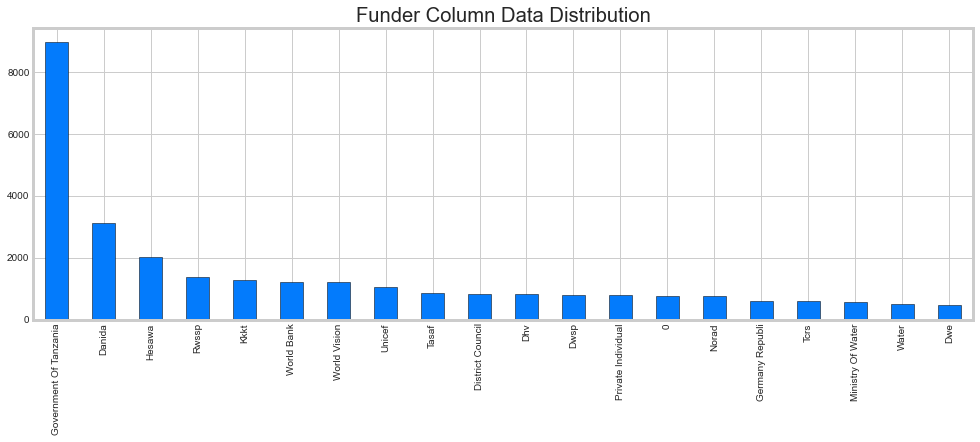

In [73]:
# Get the value counts of the funder column
get_value_counts(new_data, 'funder')

# Visualise the data in the funder column
plot_data(new_data, 'funder', 'Funder Column Data Distribution')